In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dgr_bert_model import *
from dgr_utils import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [4]:
"""
Builds and trains a BertLSTM model
best F1 score: 0.854
"""

'\nBuilds and trains a BertLSTM model\nbest F1 score: 0.854\n'

In [5]:
sample_column_name = "string"
columns_to_keep = ['string', 'label', 'citeStart', 'citeEnd']

train_dataset_file_path = "../../data/raw/train.jsonl"
test_dataset_file_path = "../../data/raw/test.jsonl"

label_to_index = {
    "background": 0,
    "method": 1,
    "result": 2
}

# Load dataset
df_train = load_dataset_raw(train_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)
df_test = load_dataset_raw(test_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)

# {'background': 0, 'method': 1, 'result': 2}
unique_labels = df_train['label'].unique()

In [6]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# processing the dataset
print("Processing train dataset...")
texts_train, labels_train = process_data_bert(df_train, label_to_index)

print("Processing test dataset...")
texts_test, labels_test = process_data_bert(df_test, label_to_index)

print('Total number of training samples: {}'.format(len(texts_train)))
print('Total number of test samples: {}'.format(len(texts_test)))

Processing train dataset...


100%|██████████| 8240/8240 [00:00<00:00, 20651.20it/s]


Processing test dataset...


100%|██████████| 1857/1857 [00:00<00:00, 20865.17it/s]

Total number of training samples: 8240
Total number of test samples: 1857


In [8]:
# tokenize dataset with bert tokenizer

max_seq_length = 128

tokens_train = bert_tokenizer.batch_encode_plus(
    texts_train,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

tokens_test = bert_tokenizer.batch_encode_plus(
    texts_test,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

In [9]:
# generate sequence, mask and labels

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(labels_train)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(labels_test)

In [10]:
# dataset label counts
counts = torch.bincount(train_y)
print(counts)

tensor([4840, 2293, 1107])


In [11]:
# define dataloaders

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(test_seq, test_mask, test_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [12]:
for X, mask, y in train_dataloader:
    print('X.shape:', X.shape)
    print('mask.shape:', mask.shape)
    print('y.shape:', y.shape)
    break

X.shape: torch.Size([32, 128])
mask.shape: torch.Size([32, 128])
y.shape: torch.Size([32])


In [13]:
# initialize bert lstm model
bert_lstm = BertLSTM(bert_model)
bert_lstm = bert_lstm.to(device)

print(bert_lstm)

BertLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [14]:
class_weights = torch.tensor([1 / counts[0].item(), 
                              1 / counts[1].item(), 
                              1 / counts[2].item()]).to(device)

criterion  = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(bert_lstm.parameters(), lr=0.0005)

In [15]:
num_epochs = 25

results = train_bert(bert_lstm, train_dataloader, val_dataloader, 
                optimizer, criterion, num_epochs, device, verbose=True)

Total Training Time (total number of epochs: 25)


100%|██████████| 59/59 [00:12<00:00,  4.61it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 1] loss:	232.167, f1 train: 0.765, f1 test: 0.779 


100%|██████████| 59/59 [00:12<00:00,  4.61it/s]


[Epoch 2] loss:	196.083, f1 train: 0.774, f1 test: 0.777 


100%|██████████| 59/59 [00:12<00:00,  4.54it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 3] loss:	188.062, f1 train: 0.793, f1 test: 0.797 


100%|██████████| 59/59 [00:13<00:00,  4.50it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 4] loss:	182.213, f1 train: 0.821, f1 test: 0.831 


100%|██████████| 59/59 [00:13<00:00,  4.52it/s]


[Epoch 5] loss:	180.115, f1 train: 0.778, f1 test: 0.794 


100%|██████████| 59/59 [00:14<00:00,  4.02it/s]


[Epoch 6] loss:	173.172, f1 train: 0.821, f1 test: 0.820 


100%|██████████| 59/59 [00:14<00:00,  4.01it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 7] loss:	166.949, f1 train: 0.841, f1 test: 0.850 


100%|██████████| 59/59 [00:15<00:00,  3.85it/s]


[Epoch 8] loss:	164.917, f1 train: 0.843, f1 test: 0.842 


100%|██████████| 59/59 [00:15<00:00,  3.89it/s]


[Epoch 9] loss:	160.579, f1 train: 0.818, f1 test: 0.796 


100%|██████████| 59/59 [00:15<00:00,  3.84it/s]


[Epoch 10] loss:	158.932, f1 train: 0.851, f1 test: 0.813 


100%|██████████| 59/59 [00:15<00:00,  3.88it/s]


[Epoch 11] loss:	156.450, f1 train: 0.828, f1 test: 0.802 


100%|██████████| 59/59 [00:15<00:00,  3.90it/s]


[Epoch 12] loss:	147.354, f1 train: 0.877, f1 test: 0.836 


100%|██████████| 59/59 [00:15<00:00,  3.79it/s]


[Epoch 13] loss:	145.973, f1 train: 0.869, f1 test: 0.827 


100%|██████████| 59/59 [00:15<00:00,  3.75it/s]


[Epoch 14] loss:	142.387, f1 train: 0.876, f1 test: 0.822 


100%|██████████| 59/59 [00:15<00:00,  3.73it/s]


[Epoch 15] loss:	141.158, f1 train: 0.897, f1 test: 0.825 


100%|██████████| 59/59 [00:15<00:00,  3.85it/s]


[Epoch 16] loss:	137.798, f1 train: 0.883, f1 test: 0.817 


100%|██████████| 59/59 [00:15<00:00,  3.73it/s]


[Epoch 17] loss:	135.392, f1 train: 0.888, f1 test: 0.806 


100%|██████████| 59/59 [00:16<00:00,  3.63it/s]


[Epoch 18] loss:	130.542, f1 train: 0.913, f1 test: 0.820 


100%|██████████| 59/59 [00:16<00:00,  3.60it/s]


[Epoch 19] loss:	123.609, f1 train: 0.924, f1 test: 0.818 


100%|██████████| 59/59 [00:15<00:00,  3.89it/s]


[Epoch 20] loss:	123.750, f1 train: 0.904, f1 test: 0.804 


100%|██████████| 59/59 [00:14<00:00,  3.94it/s]


[Epoch 21] loss:	120.730, f1 train: 0.894, f1 test: 0.787 


100%|██████████| 59/59 [00:14<00:00,  3.93it/s]


[Epoch 22] loss:	117.418, f1 train: 0.950, f1 test: 0.845 


100%|██████████| 59/59 [00:14<00:00,  3.93it/s]


[Epoch 23] loss:	116.811, f1 train: 0.946, f1 test: 0.828 


100%|██████████| 59/59 [00:15<00:00,  3.86it/s]


[Epoch 24] loss:	114.870, f1 train: 0.950, f1 test: 0.832 


100%|██████████| 59/59 [00:16<00:00,  3.62it/s]


[Epoch 25] loss:	111.435, f1 train: 0.937, f1 test: 0.815 


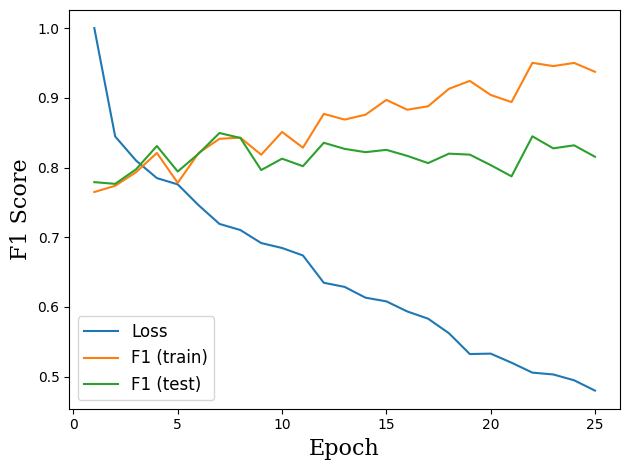

In [16]:
plot_training_results(results)

100%|██████████| 59/59 [00:12<00:00,  4.59it/s]

Evaluating model: data/model_bert_854.pth
F1 score for model: 0.854


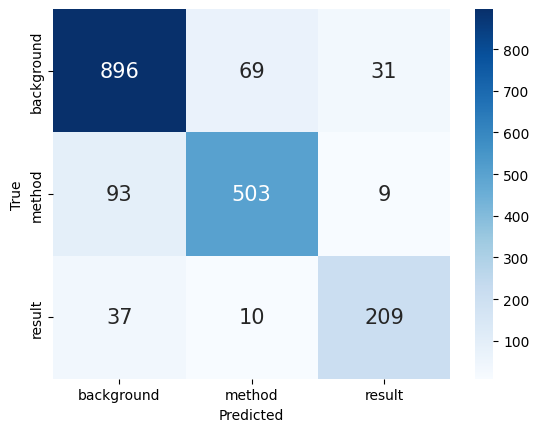

              precision    recall  f1-score   support

  background       0.87      0.90      0.89       996
      method       0.86      0.83      0.85       605
      result       0.84      0.82      0.83       256

    accuracy                           0.87      1857
   macro avg       0.86      0.85      0.85      1857
weighted avg       0.87      0.87      0.87      1857


In [18]:
# 'data/model_bert_836.pth' -> [Epoch 16] loss:	131.768, f1 train: 0.916, f1 test: 0.836
model_path = 'data/model_bert_854.pth'

eval_model = torch.load(model_path)

y_true, y_pred = evaluate_bert(eval_model, val_dataloader, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list, annot_kws={"size": 15})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)